#### Import Packages for building the model

In [18]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

#### Read the excel that contains 1024 records

In [2]:
hypo_df=pd.read_excel('C:\\Users\\koushikbaktha\\Downloads\\hypothyroidism_1024_records_updated_boolean.xlsx')

#### Modify the race from text to discrete variables E.g., Hispanic and Latino to 1, Black or African American to 2 etc.,

In [3]:
hypo_df['Race'].unique()

array(['0n-Hispanic White', 'Hispanic and Lati0',
       'Black or African American', 'Asian', 'Two or More Races',
       'Native Hawaiians', 'Native Americans and Alaska Natives'],
      dtype=object)

In [4]:
dict1={'0n-Hispanic White':0, 'Hispanic and Lati0':1,
       'Black or African American':2, 'Asian':3, 'Two or More Races':4,
       'Native Hawaiians':5, 'Native Americans and Alaska Natives':6}

In [5]:
hypo_df['Race']=hypo_df.Race.map(dict1)

#### Modify similarly for Sex from Text to 0 / 1 (boolean) variable

In [6]:
dict2={'Male':1,'Female':0}

In [7]:
hypo_df['Sex']=hypo_df.Sex.map(dict2)

#### Modified dataset with boolean variables

In [23]:
hypo_df.head()

,Age,Sex,Race,fatigue,weight_gain,cold_intolerance,constipation,dry_skin,poor_memory,me0rrhagia,leg_edema,periorbital_edema,carpal_tunnel_syndrome,Recommended for TSH Test?
0,59,0,0,1,1,1,1,1,1,1,1,1,1,1
1,62,1,0,1,1,1,1,1,1,1,1,1,0,1
2,52,1,0,1,1,1,1,1,1,1,1,0,1,1
3,31,1,1,1,1,1,1,1,1,1,1,0,0,1
4,53,1,1,1,1,1,1,1,1,1,0,1,1,1


#### Recommended for TSH Test has labels 1 and 0.
#### 1 means that based on the data, Doctor prescribed and recommended for a TSH test and 0 means TSH test is not required.
#### 909 data points require a TSH Test and 115 do not require a TSH Test

In [9]:
hypo_df['Recommended for TSH Test?'].value_counts()

1    909
0    115
Name: Recommended for TSH Test?, dtype: int64

In [10]:
total_data=hypo_df.copy()

##### Below lines of code does multiple steps,
##### 1. KFold Cross validation actually splits the dataset into 10 chunks and each chunk will be then utilized for training and validation of model.
##### 2. Random Forest Classifier (RFClassifier) is a Machine Learning Algorithm used for predicting the class label 0 / 1 based on the dataset. 
##### 3. Dataset is split into 2 unequal halves, one for training the ML model and for testing the ML Model with unknown data.

In [30]:
dataset=shuffle(total_data,random_state=1)
kfold = KFold(n_splits=10,shuffle=True,random_state=4)
principaldata=dataset.drop(columns='Recommended for TSH Test?')
scores_rf = []
scores_rf1=[]
model=RandomForestClassifier(criterion="entropy")
for train_index, test_index in kfold.split(principaldata):
    X_train,X_test,y_train,y_test = principaldata.loc[train_index],principaldata.loc[test_index],\
    dataset['Recommended for TSH Test?'].loc[train_index],dataset['Recommended for TSH Test?'].loc[test_index]
    model.fit(X_train,y_train)
    scores_rf.append(model.score(X_test,y_test))
    scores_rf1.append(model.score(X_train,y_train))
y_prediction_label=model.predict(X_test)

#### Parameters of the model.

In [31]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

#### Create Confusion Matrix of the model output labels vs prediction labels.

In [32]:
cm=metrics.confusion_matrix(y_test,y_prediction_label, labels=[1,0])

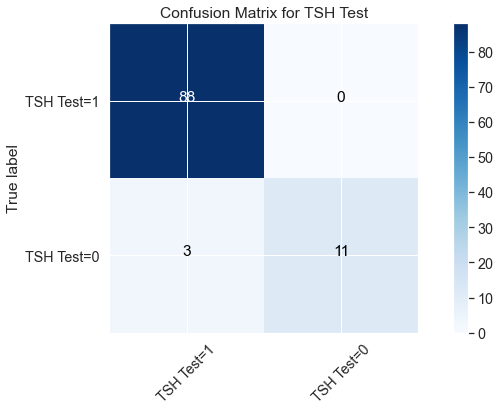

In [33]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(cm, 
                          classes=['TSH Test=1','TSH Test=0'],
                          normalize= False,  
                          title='Confusion Matrix for TSH Test')
plt.show()

In [34]:
print('Prediction score for test is',np.mean(scores_rf*100))

Prediction score for test is 0.957024557395774


In [35]:
print('Prediction score for training is',np.mean(scores_rf1*100))

Prediction score for training is 1.0


In [21]:
def plot_roc_chart(model):
     # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.figure(figsize=(8,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
#     return probs

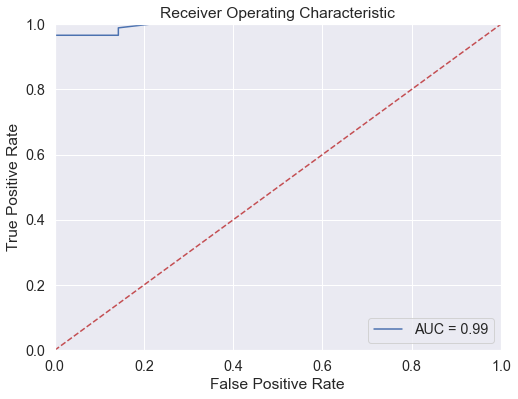

In [24]:
plot_roc_chart(model)